<a href="https://colab.research.google.com/github/sopo9909/spring/blob/master/OCR_by_Ho050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
!mkdir -p UntitledFolder

In [5]:
img_list = glob('UntitledFolder/*')
# 새폴더 만들어서 png파일 다 넣어주세유!
len(img_list)

1199

In [6]:
!mkdir -p UntitledFolder1

In [45]:
for img_alone in img_list:
  image = cv2.imread(img_alone,cv2.IMREAD_UNCHANGED)
  trans_mask= image[:,:,3]== 0
  image[trans_mask]= [255, 255, 255, 255]
  new_img= cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  (thresh, blackAndWhiteImage) = cv2.threshold(new_img, 127, 255, cv2.THRESH_BINARY)
  cv2.imwrite('UntitledFolder1/'+img_alone.replace('UntitledFolder/',''),blackAndWhiteImage)

In [46]:
img_list2 = glob('UntitledFolder1/*')
len(img_list2)

1199

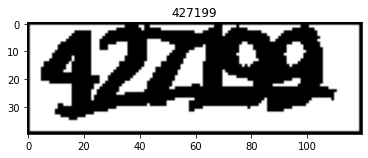

In [47]:
img = cv2.imread(img_list2[0])
label = os.path.splitext(os.path.basename(img_list2[0]))[0]
plt.title(label)
plt.imshow(img)

In [48]:
imgs = []
labels = []
max_length = 0

for img_path in img_list2:
  imgs.append(img_path)

  label = os.path.splitext(os.path.basename(img_path))[0]
  labels.append(label)

  if len(label) > max_length:
    max_length = len(label)

print(len(imgs), len(labels), max_length)

1199 1199 6


In [49]:
''.join(labels)

'427199882227860788622521379913514703353868565037351994500825521930371924415771393831253783180488698844443402099807035709020759960091248229170215247048835454264543519993772554974754179049239848479242853759087350388259817707173896153269359127004265081452412227250540635751871868239838011189858603575608508268673091044140138490181093006821158284199526434396461508904563244992488626255359539339685048297443331410063245670855614629670312719868846061395805374134715185184599813957888408558724744606284303713222818975935722041879644159739107666109375107015124754981487732333354546719178833950605770427566024651885518384733415195661196031954694616721546367768599742933554723506553346758213053000765437930907264780009452312453357322343900383502850542631507182273614908238209936992940422435631262062921305438562972764023862293487683034321887125726287588985064377040656840989867879400068335917504222877964516229497339366224168407605300361250008060169799787275450514270924598077133499397247721631656784023222363

In [50]:
characters = set(''.join(labels))
characters 

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [57]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0, mask_token=None, invert=True
)

print(labels[0])
encoded = char_to_num(tf.strings.unicode_split(labels[0], input_encoding='UTF-8'))
print(encoded)

427199
tf.Tensor([7 2 5 9 4 4], shape=(6,), dtype=int64)


In [58]:
tf.strings.reduce_join(num_to_char(encoded)).numpy().decode('utf-8')

'427199'

In [59]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.1, random_state=2021)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

1079 1079
120 120


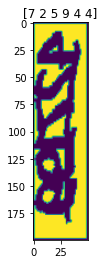

In [60]:
img_width = 200
img_height = 50

def encode_single_sample(img_path, label):
  # 1. Read image
  img = tf.io.read_file(img_path)
  # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)
  # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])
  # 6. Map the characters in label to numbers
  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  # 7. Return a dict as our model is expecting two inputs
  return {'image': img, 'label': label}

preview = encode_single_sample(imgs[0], labels[0])

plt.title(str(preview['label'].numpy()))
plt.imshow(preview['image'].numpy().squeeze())

In [62]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(validation_dataset)

<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>
<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>


In [64]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None,**kwargs):
        super().__init__(name=name,**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [65]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
34/34 [==============================] - 12s 162ms/step - loss: 23.7324 - val_loss: 15.6746
Epoch 2/100
34/34 [==============================] - 4s 110ms/step - loss: 15.5962 - val_loss: 15.6725
Epoch 3/100
34/34 [==============================] - 4s 114ms/step - loss: 15.5667 - val_loss: 15.6475
Epoch 4/100
34/34 [==============================] - 4s 113ms/step - loss: 15.5299 - val_loss: 15.4857
Epoch 5/100
34/34 [==============================] - 4s 115ms/step - loss: 15.3247 - val_loss: 15.1002
Epoch 6/100
34/34 [==============================] - 4s 115ms/step - loss: 14.7373 - val_loss: 14.1559
Epoch 7/100
34/34 [==============================] - 4s 115ms/step - loss: 13.6499 - val_loss: 12.3114
Epoch 8/100
34/34 [==============================] - 4s 113ms/step - loss: 11.2113 - val_loss: 7.9415
Epoch 9/100
34/34 [==============================] - 4s 114ms/step - loss: 6.6928 - val_loss: 3.2657
Epoch 10/100
34/34 [==============================] - 4s 114ms/step - loss:

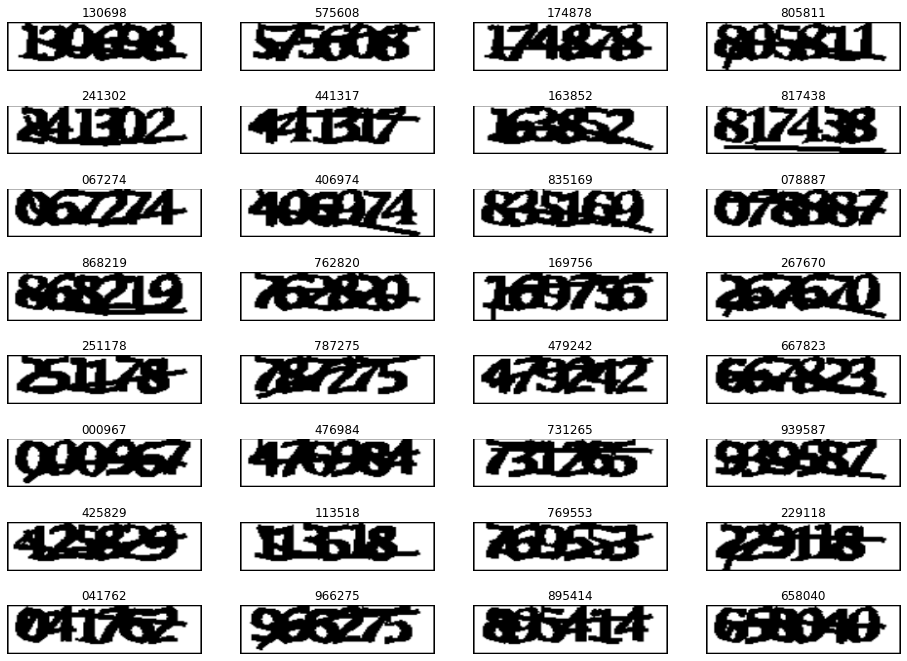

In [66]:
prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

for batch in validation_dataset.take(1):
    batch_images = batch['image']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(8, 4, figsize=(16, 12))

    for img, text, ax in zip(batch_images, pred_texts, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T

        ax.imshow(img, cmap='gray')
        ax.set_title(text)
        ax.set_axis_off()

In [76]:
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
# Save model weights
model.save_weights("prediction_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [79]:
# model load
from keras.models import model_from_json 
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
new_model = model_from_json(loaded_model_json,custom_objects={'CTCLayer':CTCLayer})
 
# model weight load 
new_model.load_weights("prediction_model_weight.h5")
print("Loaded model from disk")

Loaded model from disk


여기 통과

In [21]:
#prediction_model.save('prediction_model.h5')

In [80]:
#new_model = tf.keras.models.load_model('/content/prediction_model.h5')

# 모델 구조를 확인합니다
new_model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [81]:
characters = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0, mask_token=None, invert=True
)

In [24]:
!mkdir -p Predict

In [25]:
!cd Predict
!mkdir -p Predict/new
!cd ..

In [82]:
prediction_model = keras.models.Model(
  new_model.get_layer(name='image').input, new_model.get_layer(name='dense2').output
)
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text
def input_new2(data2):
  image = cv2.imread(data2,cv2.IMREAD_UNCHANGED)
  trans_mask= image[:,:,3]== 0
  image[trans_mask]= [255, 255, 255, 255]
  new_img= cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  (thresh, blackAndWhiteImage) = cv2.threshold(new_img, 127, 255, cv2.THRESH_BINARY)
  plt.imshow(blackAndWhiteImage)
  predictfile='Predict/new/'+data2.replace('Predict/','')
  print(predictfile)
  cv2.imwrite(predictfile,blackAndWhiteImage)
  return predictfile

Predict/new/황호영.png


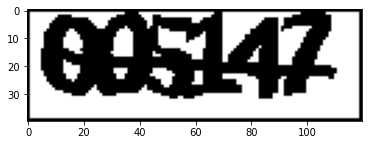

In [83]:
img_width = 200
img_height = 50
max_length=6
def encode_single_sample2(img_path):
  # 1. Read image
  img = tf.io.read_file(img_path)
  # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)
  # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])
  # 6. Map the characters in label to numbers
  # 7. Return a dict as our model is expecting two inputs
  return {'image': img}

preview = encode_single_sample2(input_new2('Predict/황호영.png')) #여기에 Predict 라는 폴더 안에 

In [84]:
preds = prediction_model.predict(tf.reshape(preview['image'], [-1,200,50,1]))
pred_texts = decode_batch_predictions(preds)
print('결과는?!?!?!?!?:               '+pred_texts[0])

결과는?!?!?!?!?:               005146
